In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import monthrange
from glob import glob
import pickle
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Sample count per density per year


In [2]:
truth_dir = '/scratch/alpine/mecr8410/semantic_segmentation_smoke/filtered_data/truth/'
sample_counts = pd.DataFrame({'Light' : [0, 0, 0, 0, 0, 0],
                              'Medium': [0, 0, 0, 0, 0, 0],
                              'Heavy' : [0, 0, 0, 0, 0, 0]},
                             index=['2018', '2019', '2020', '2021', '2022', '2023'])
for yr in sample_counts.index:
    for density in list(sample_counts):
        num_samples =  len(os.listdir("{}{}/{}/".format(truth_dir, yr, density)))
        sample_counts.loc[yr, density] = num_samples
print(sample_counts)

      Light  Medium  Heavy
2018  20415    3841   1955
2019  19414    4993   2587
2020  21944    6305   3334
2021  11780    4282   3176
2022   9173    4481   2155
2023   8084    4121   2460


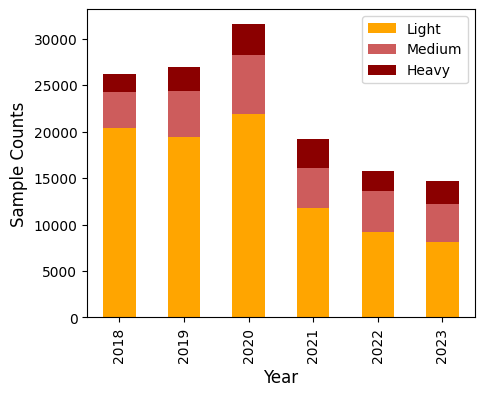

In [10]:
sample_counts.plot(figsize=(5,4),kind='bar', stacked=True, color=['orange', 'indianred', 'darkred'])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sample Counts', fontsize=12)
plt.savefig('figures/sample_count_per_yr.png', dpi=300)

### Sample Count Per Density Per Month of the Year 

In [4]:
month_counts = pd.DataFrame({'2018' : [0]*12, '2019' : [0]*12, '2020' : [0]*12, '2021' : [0]*12, '2022' : [0]*12, '2023' : [0]*12},
                             index = list(range(1,13)))
for yr in list(month_counts):
    curr_dn = 0
    for month in month_counts.index:
        days = monthrange(int(yr), int(month))
        for day in range(1,days[1]+1):
            curr_dn += 1
            dn_str = str(curr_dn).zfill(3)
            num_dn_samples =  len(glob("{}{}/*/G1*_s{}{}*tif".format(truth_dir, yr, yr, dn_str)))
            month_counts.loc[month, yr] += num_dn_samples

In [5]:
month_counts

,2018,2019,2020,2021,2022,2023
1,2012,1444,5181,1830,1901,1602
2,831,1282,7414,2316,1720,2227
3,4851,3580,9936,5304,2528,3681
4,4808,3710,8926,5961,1844,2099
5,2291,2810,7661,3515,1075,1823
6,1740,1061,5241,2983,898,2094
7,1856,1609,5421,3275,705,1219
8,2040,2050,6496,2483,1224,1487
9,1809,2543,3601,1600,1016,1698
10,2111,2844,5221,1893,1886,2559


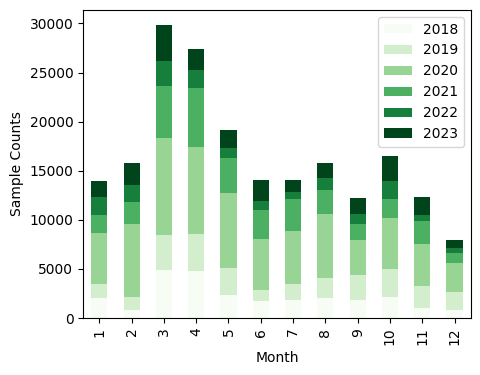

In [13]:
month_counts.plot(figsize=(5,4), kind='bar', stacked=True, cmap='Greens')
plt.xlabel('Month')
plt.ylabel('Sample Counts')
plt.savefig('figures/sample_count_per_month.png', dpi=300)

### Sample count per area - US state and North American country

In [14]:
lat_lon_pkl = './geo_dependent/dict_lat_lon_fn.pkl'
with open(lat_lon_pkl, 'rb') as handle:
    lat_lon_dict = pickle.load(handle)
states = geopandas.read_file('./shape_files/states.shp')
countries = geopandas.read_file('./shape_files/NA_countries.shp')

lat_lon_df = pd.DataFrame(lat_lon_dict)
geometry= geopandas.points_from_xy(x=lat_lon_df['Latitude'],y=lat_lon_df['Longitude'], crs=states.crs)
gdf=geopandas.GeoDataFrame(lat_lon_df, geometry=geometry)

In [15]:
states_dict = {}
for idx, row in states.iterrows():                                                                                                                       
    state_dict = {row['shapeISO']: 0}
    states_dict.update(state_dict)
countries_dict = {}
for idx, row in countries.iterrows():                                                                                                                       
    country_dict = {row['shapeISO']: 0}
    countries_dict.update(country_dict)

In [16]:
for idx, row in states.iterrows():
    states_dict[row['shapeISO']] = len(gdf.geometry.clip(row['geometry']))
for idx, row in countries.iterrows():
    countries_dict[row['shapeISO']] = len(gdf.geometry.clip(row['geometry']))

In [17]:
print(countries_dict)

{'CAN': 11752, 'MEX': 19396, 'USA': 87822}


In [18]:
print(state_dict)

{'US-CT': 0}


In [19]:
def assign_state_smoke_count(states):    
    count = states_dict[states['shapeISO']]
    states['smoke_count'] = count                                                                                                                                         
    return states
states = states.apply(assign_state_smoke_count, axis=1)
def assign_country_smoke_count(countries):    
    count = countries_dict[countries['shapeISO']]
    countries['smoke_count'] = count                                                                                                                                         
    return countries
countries = countries.apply(assign_country_smoke_count, axis=1)

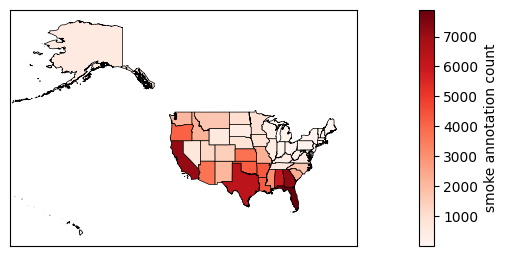

In [32]:
color = 'Reds'
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-.1)
states.plot(figsize=(5,4), column='smoke_count', cmap=color, edgecolor='black', linewidth=.5, ax=ax, legend=True, cax=cax, legend_kwds={'label': "smoke annotation count",'orientation': "vertical"})
ax.get_yaxis().set_visible(False)                                                                                                                        
ax.get_xaxis().set_visible(False)   
ax.set_xlim(-180,-60)
plt.savefig('figures/sample_count_per_state.png', bbox_inches='tight', dpi=300)                                                                           

plt.show()
#ax.set_title('Count of Smoke Annotations')                                                                                            
#plt.close()         

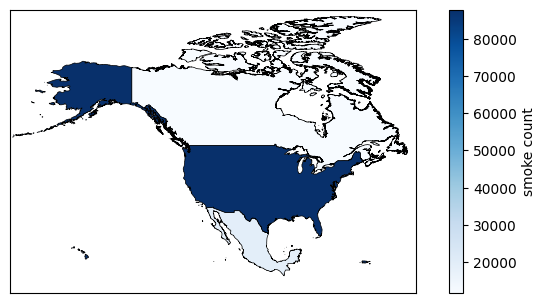

In [31]:
color = 'Blues'
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-.1)
countries.plot(column='smoke_count', cmap=color, edgecolor='black', linewidth=.5, ax=ax, legend=True, cax=cax, legend_kwds={'label': "smoke count",'orientation': "vertical"})
ax.get_yaxis().set_visible(False)                                                                                                                        
ax.get_xaxis().set_visible(False)   
ax.set_xlim(-180,-50)
ax.set_ylim(10,85)
plt.savefig('figures/sample_count_per_country.png', bbox_inches='tight',dpi=300)                                                                           

plt.show()

## Model Perfomance Statistics

### variations in model performance on testset over the year

how does IoU change based on month of year the data is taken from?

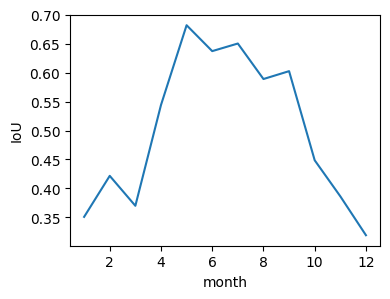

In [30]:
month_IoU = [0.3509, 0.42175, 0.37003, 0.544104, 0.68193, 0.6372, 0.65033, 0.58900, 0.60259, 0.448644, 0.38638, 0.3192]

fig = plt.figure(figsize=(4, 3))
plt.plot( list(range(1,13)), month_IoU)
plt.xlabel('month')
plt.ylabel('IoU')
plt.savefig('figures/IoU_per_month.png', bbox_inches='tight',dpi=300)                                                                           

plt.show()

### Geographical variations in model performance

we separate into 4 regions based on the mid-point (40, -100) and run the model on each sub-testset

In [ ]:
geo_counts = {'NW': 0, 'SW': 0, 'NE': 0, 'SE': 0}
def count_section(lat, lon):
    if lat > 40 and lon < -100:
        geo_counts['NW']+=1
    elif lat < 40 and lon < -100:
        geo_counts['SW']+=1
    elif lat > 40 and lon > -100:
        geo_counts['NE']+=1
    elif lat < 40 and lon > -100:
        geo_counts['SE']+=1
for idx, row in lat_lon_df.iterrows():
    count_section(row['Longitude'], row['Latitude'])

In [15]:
print(geo_counts)

{'NW': 23335, 'SW': 26577, 'NE': 8392, 'SE': 76130}



| Geographical region | Overall testset IoU | Number test samples | Total number of samples |
| -------- | ------- |  ------- |  ------- | 
| NW | 0.5932 | 1425 | 23335 |
| SW | 0.6094 | 1131 | 26577 |
| NE | 0.4726 | 252 | 8392 |
| SE | 0.4706 | 4666 | 76130 |

### Satellite source variation in model performance

Are there variations in model performance depending on which satellite the data is sourced from

In [25]:
sat_counts = {'G16' : 0, 'G17': 0 }
densities = ['Heavy', 'Medium', 'Light']
for density in densities:
    sat_counts['G16']+=len(glob('{}/*/{}/G16_*.tif'.format(truth_dir,density)))
    sat_counts['G17']+=len(glob('{}/*/{}/G17_*.tif'.format(truth_dir,density)))
    sat_counts['G17']+=len(glob('{}/*/{}/G18_*.tif'.format(truth_dir,density)))

print(sat_counts)

{'G16': 119040, 'G17': 30640}



| Satellite | Overall Test Set IoU | Number Test Samples | Total number of samples in full dataset|
| -------- | ------- |  ------- |  ------- | 
| GOES-WEST | 0.6450 | 1827 | 30640 |
| GOES-EAST | 0.4827 | 5647 | 119040 |

### Temporal proximity to sunrise/sunset

| time difference | Mie DS IoU | PL DS IoU|
| -------- | ------- | ------- |
| <2 hours  | 0.412 | 0.546 |
| >2 hours  |  0.411 | 0.538 |

shows the overall IoU values for the Mie or pseudo-labeled test dataset samples that are within or outside 2 hours of either sunrise or sunset.

### Sample count proximity to sunrise/sunset for Mie vs pseudo-label derived datasets

| time difference | Mie DS | PL DS |
| -------- | ------- | ------- |
| <2 hours  | 3923 (63%) | 3436 (46%) |
| >2 hours  | 2280 (37%) | 4038 (54%) |

shows the split on if the Mie or pseudo-labeled test dataset samples that are within or outside 2 hours of either sunrise or sunset. The Mie dataset is skewed towards the nighttime boundaries. 
